# Importing packages

In [13]:
import random
import numpy as np
import igraph
from sklearn import svm
from sklearn import tree
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
import nltk
import csv
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,f1_score
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search


from xgboost import XGBClassifier, DMatrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Creating Feature Matrix on train data and test data



## *Doing preprocessing*

In [14]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package punkt to /home/ahla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ahla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#Importing training and testing set

with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]


with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)
    
testing_set = [element[0].split(" ") for element in testing_set]

    

print("testing_set length ",len(testing_set))
print("training_set length ",len(training_set))

testing_set length  32648
training_set length  615512


In [44]:
# data loading and preprocessing 

# the columns of the data frame below are: 
# (1) paper unique ID (integer)
# (2) publication year (integer)
# (3) paper title (string)
# (4) authors (strings separated by ,)
# (5) name of journal (optional) (string)
# (6) abstract (string) - lowercased, free of punctuation except intra-word dashes



with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

# compute TFIDF vector of each paper
corpus = [element[5] for element in node_info]
vectorizer = TfidfVectorizer(stop_words="english")
# each row is a node in the order of node_info
features_TFIDF = vectorizer.fit_transform(corpus)

## constructing a graph with igraph

edges = [(element[0],element[1]) for element in training_set if element[2]=="1"]

## some nodes may not be connected to any other node
## hence the need to create the nodes of the graph from node_info.csv,
## not just from the edge list

nodes = IDs

## create empty directed graph
g = igraph.Graph(directed=True)
 
## add vertices
g.add_vertices(nodes)
 
## add edges
g.add_edges(edges)


# convert labels into integers then into column array
labels = [int(element[2]) for element in training_set]
labels = list(labels)
labels_array = np.array(labels)

# Save labels in a csv
pd.DataFrame(labels_array).to_csv('labels.csv')


## *Extracting features on train data*

In [22]:
# number of overlapping words in title
overlap_title = []

# temporal distance between the papers
temp_diff = []

# number of common authors
comm_auth = []

#common journals
comm_journal = []

#common neighbors
comm_neighbors = []

#same author
same_author = []

#Jaccar coeff
jaccar = []

#Similarity measure for abstracts
cos_similarity = []

#inlinkdiff
in_link_diff = []

#eccentricity
eccentricity = []

#tolink
to_link = []

#cocitation
cocitation = []

counter = 0

for i in range(len(training_set)):
    
    source = training_set[i][0]
    target = training_set[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
    source_journal=source_info[4]
    target_journal=target_info[4]
    
	# convert to lowercase and tokenize
    source_title = source_info[2].lower().split(" ")
	# remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title] 
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    source_neighbors = g.neighbors(index_source)
    target_neighbors = g.neighbors(index_target)
    
    source_in = g.indegree(index_source)
    source_out = g.outdegree(index_source)

    target_in = g.indegree(index_target)
    target_out = g.outdegree(index_target)
    
    in_link_diff.append((source_in - source_out) - (target_in - target_out))
    to_link.append(target_in)
    eccentricity.append(g.eccentricity(index_source)-g.eccentricity(index_target))
       
    cos_similarity.append(cosine_similarity(features_TFIDF[index_source], features_TFIDF[index_target]))
    jaccar.append(len(set(source_neighbors).intersection(set(target_neighbors)))/max(1,len(set(source_neighbors).union(set(target_neighbors)))))
    
    comm_neighbors.append(len(set(source_neighbors).intersection(set(target_neighbors))))
    if source_auth == "" or target_auth == "":
        same_author.append(0)
    else:
        same_author.append(len(set(source_auth).intersection(set(target_auth)))>0)
        
    if source_journal == "" or target_journal == "":
        comm_journal.append(0)
    elif source_journal == target_journal:
        comm_journal.append(1)
    else:
        comm_journal.append(0)
        
    overlap_title.append(len(set(source_title).intersection(set(target_title))))
    temp_diff.append(int(source_info[1]) - int(target_info[1]))
    comm_auth.append(len(set(source_auth).intersection(set(target_auth))))
    cocitation.append(g.cocitation(index_source)[0][index_target])

    
   
    counter += 1
    if counter % 500 == True:
        print( counter, "training examples processsed")
        

# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
training_features = np.array([overlap_title, temp_diff, comm_auth, comm_journal,comm_neighbors, same_author, jaccar, in_link_diff,to_link,eccentricity, cocitation, cos_similarity]).T

# save the training features in a csv files ( This specific CSV file is also available in the submission if the runtime is too long)
pd.DataFrame(training_features, columns = ['overlap_title', 'temp_diff', 'comm_auth', 'comm_journal','comm_neighbors', 'same_author', 'jaccar', 'in_link_diff', 'to_link','eccentricity', 'cocitation', 'cos_similarity']).to_csv('tdfv.csv')

1 training examples processsed


## *Extracting features on test data* 

In [ ]:
overlap_title_test = []
temp_diff_test = []
comm_auth_test = []
comm_journal_test = []
comm_neighbors_test = []
same_author_test = []
jaccar_test=[]
cos_similarity_test = []
in_link_diff_test = []
eccentricity_test = []
to_link_test = []
cocitation_test = []
   
counter = 0
testing_length =len(testing_set)
print(" hedhi len de testing set  ", len(testing_set))
for i in range(testing_length):
    source = testing_set[i][0]
    target = testing_set[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    

    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
    source_neighbors = g.neighbors(index_source)
    target_neighbors = g.neighbors(index_target)
    
    source_in = g.indegree(index_source)
    source_out = g.outdegree(index_source)

    target_in = g.indegree(index_target)
    target_out = g.outdegree(index_target)
    
    in_link_diff_test.append((source_in - source_out) - (target_in - target_out))
    to_link_test.append(target_in)
    eccentricity_test.append(g.eccentricity(index_source)-g.eccentricity(index_target))
    
    source_journal = source_info[4]
    target_journal = target_info[4]
    
    source_title = source_info[2].lower().split(" ")
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    source_abstract = source_info[5]
    target_abstract = target_info[5]
    
    if source_auth == "" or target_auth == "":
        same_author_test.append(0)
    else:
        same_author_test.append(len(set(source_auth).intersection(set(target_auth)))>0)
        
    if source_journal == "" or target_journal == "":
        comm_journal_test.append(0)
    elif source_journal == target_journal: 
        comm_journal_test.append(1)
    else: 
        comm_journal_test.append(0)  
        
    cos_similarity_test.append(cosine_similarity(features_TFIDF[index_source], features_TFIDF[index_target]))

    jaccar_test.append(len(set(source_neighbors).intersection(set(target_neighbors)))/max(1,len(set(source_neighbors).union(set(target_neighbors)))))

    comm_neighbors_test.append(len(set(source_neighbors).intersection(set(target_neighbors))))  
    overlap_title_test.append(len(set(source_title).intersection(set(target_title))))
    temp_diff_test.append(int(source_info[1]) - int(target_info[1]))  
    comm_auth_test.append(len(set(source_auth).intersection(set(target_auth))))
    cocitation_test.append(g.cocitation(index_source)[0][index_target])
    
    
    counter += 1
    if counter % 500 == True:
        print (counter, "testing examples processsed")
        
# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
testing_features = np.array([overlap_title_test, temp_diff_test, comm_auth_test, comm_journal_test,comm_neighbors_test, same_author_test, jaccar_test, in_link_diff_test,to_link_test,eccentricity_test, cocitation_test, cos_similarity_test]).T

# save the training features in a csv files ( This specific CSV file is also available in the submission if the runtime is too long)
pd.DataFrame(testing_features, columns = ['overlap_title', 'temp_diff', 'comm_auth', 'comm_journal','comm_neighbors', 'same_author', 'jaccar', 'in_link_diff', 'to_link','eccentricity', 'cocitation', 'cos_similarity']).to_csv('tdfv.csv')

# Importing train and test data 

In [35]:
#Reading the features matrix of the train data
trainX = pd.read_csv('features_matrix_train.csv')
trainX = trainX[0:]
trainX = trainX.drop(columns= ['Unnamed: 0'])

#Reading the features matrix of the test data 
testX = pd.read_csv('features_matrix_test.csv')
testX = testX[0:]
testX = testX.drop(columns= ['Unnamed: 0'])

#Reading the prediction vector of the train data
trainY = pd.read_csv('labels.csv', names = ['pred'])
trainY = trainY.loc[0:]



# Visualization

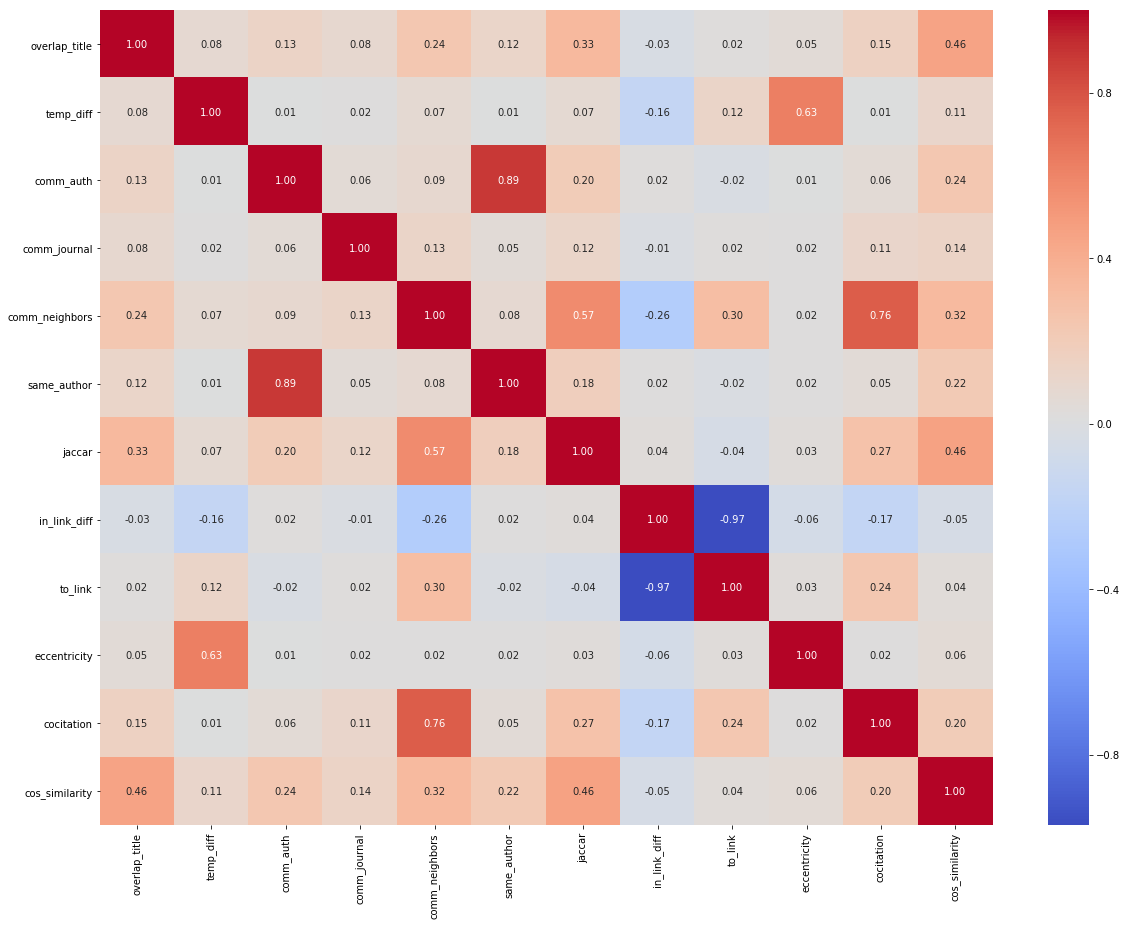

In [33]:
#Autocorrelation matrix

plt.subplots(figsize=(20,15))
sns.heatmap(trainX.corr(), annot=True, fmt=".2f", cmap = "coolwarm")

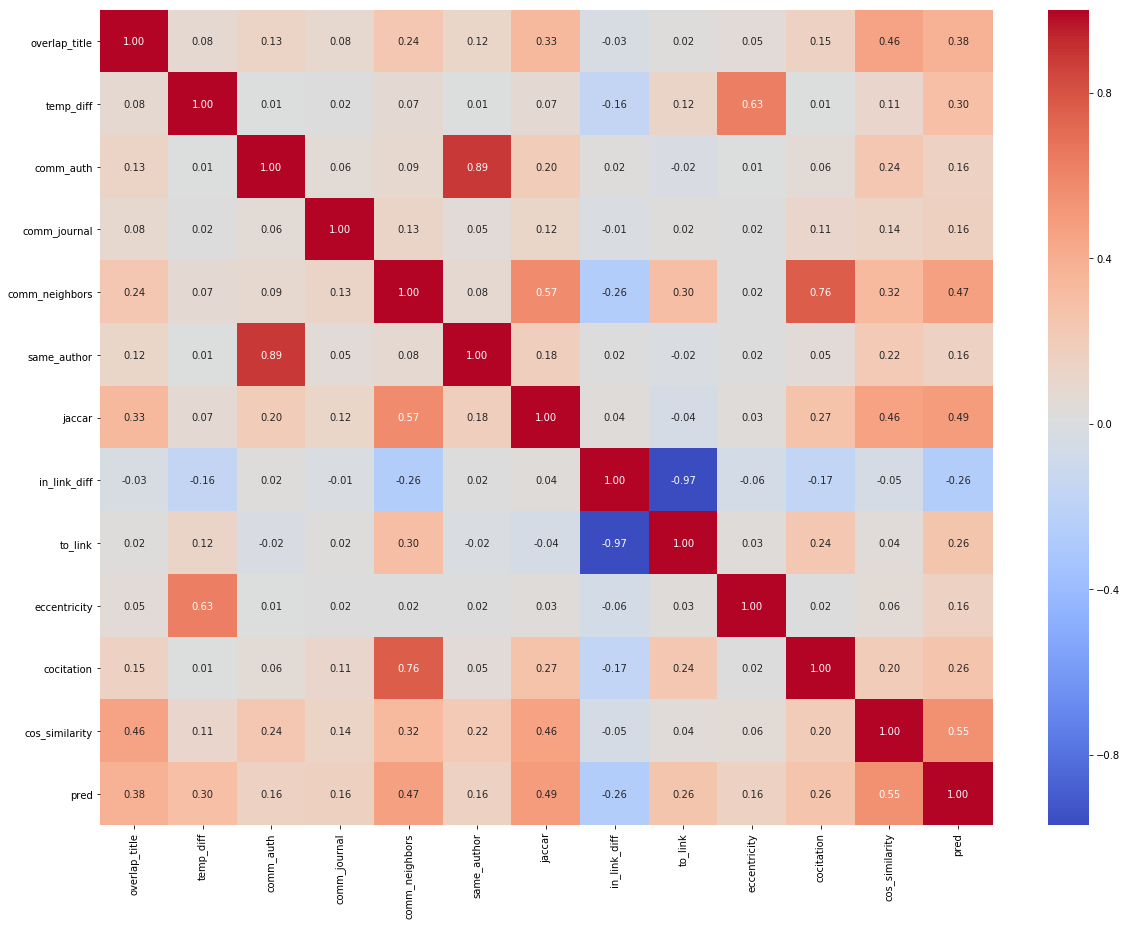

In [6]:
#Autocorrelation matrix with prediction 

fr = pd.concat([trainX,trainY], axis = 1 )
plt.subplots(figsize=(20,15))
sns.heatmap(fr.corr(), annot=True, fmt=".2f", cmap = "coolwarm")

In [7]:
#Description of the data 
trainX.describe()

,overlap_title,temp_diff,comm_auth,comm_journal,comm_neighbors,same_author,jaccar,in_link_diff,to_link,eccentricity,cocitation,cos_similarity
count,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000,615512.000000
mean,0.518416,1.156681,0.083410,0.110368,1.565242,0.064452,0.026997,-66.044987,76.440284,2.142085,2.078541,0.077654
std,0.907113,3.521691,0.357317,0.313348,2.984134,0.245557,0.049203,231.791283,229.920634,12.517423,7.238507,0.086655
min,0.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2525.000000,0.000000,-37.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.000000,4.000000,-4.000000,0.000000,0.016810
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.000000,14.000000,0.000000,0.000000,0.047564
75%,1.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.037736,3.000000,51.000000,10.000000,1.000000,0.110990
max,10.000000,11.000000,8.000000,1.000000,325.000000,1.000000,1.000000,2308.000000,2294.000000,37.000000,1414.000000,1.000000


/home/ahla/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ahla/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


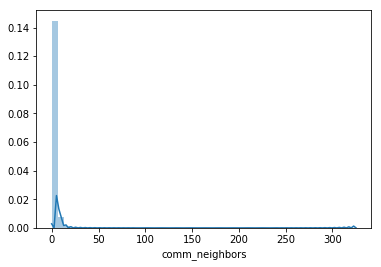

In [48]:
#Distribution plot of comm_neighbours
sns.distplot(fr['comm_neighbors'])

# Scale the data

In [39]:
#Here the split is only done for our own testing

Xtrain,Xtest,Ytrain,Ytest = train_test_split(trainX,trainY, test_size = 0.2 )

In [40]:
mean = Xtrain.mean()
std = Xtrain.std()

mean_2 = trainX.mean()
std_2 = trainX.std()

In [41]:
Xtrain=(Xtrain-mean)/std
Xtest=(Xtest-mean)/std

In [42]:
trainX = (trainX - mean_2)/ std_2
testX = (testX - mean_2)/std_2

# Load classifier

In [11]:
#Model we used, we chose XGBoost, tuned it with gridsearch and got these parameters as a result 
model = XGBClassifier(base_score=0.5440998713266354, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.7, eval_metric='logloss',
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=4, n_estimators=100, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=False, subsample=0.7)


XGBClassifier(base_score=0.5440998713266354, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.7, eval_metric='logloss',
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=4, missing=None, n_estimators=100, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=False, subsample=0.7)

# Fit classifier

In [36]:
model.fit(trainX,trainY)

/home/ahla/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ahla/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[15:35:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=7
[15:35:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=7
[15:35:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=7
[15:35:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=7
[15:35:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[15:35:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[15:35:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=7
[15:35:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=7
[15:35:3

[15:36:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[15:36:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=7
[15:36:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[15:36:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=7
[15:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=7
[15:36:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=7
[15:36:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[15:36:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=7
[15:36:34] /wo

XGBClassifier(base_score=0.5440998713266354, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.7, eval_metric='logloss',
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=4, missing=nan, n_estimators=100, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=False, subsample=0.7)

# Issue prediction

In [37]:
# issue predictions
predictions_SVM = list(model.predict(testX))


# write predictions to .csv file suitable for Kaggle (just make sure to add the column names)
predictions_SVM_2 = zip(range(len(testX)), predictions_SVM)

with open("improved_predictions.csv","w") as pred1:
    csv_out = csv.writer(pred1)
    csv_out.writerow(["id", "category"])
    for row in predictions_SVM_2:
        csv_out.writerow(row)

/home/ahla/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Compute Accuracy

In [ ]:
#Compute accuracy from a testing set:

model.fit(Xtrain,Ytrain)

In [43]:

pred4 = model.predict(Xtest)

#print("f1 Score custom threshold (Train): %f" % f1_score(Ytest, pred3[:,1]))
print("f1 Score (Train): %f" % f1_score(Ytest, pred4))

#model.predict_proba(Xtest)

/home/ahla/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ahla/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[15:39:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=7
[15:40:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=7
[15:40:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=7
[15:40:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=7
[15:40:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=7
[15:40:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[15:40:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=7
[15:40:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=7
[15:40:0

[15:40:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[15:40:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=7
[15:40:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=7
[15:40:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[15:40:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=7
[15:40:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=7
[15:40:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=7
[15:40:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=7
[15:40:53] /w

/home/ahla/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Shapley Values

In [17]:
#Visualisation of the importance of our features
#OPTIONAL : I just used it as a way of understanding the importance of each features
#it is worth noting that when features are correlated, the impact on the prediction is divided between both of them 
import shap

# load JS visualization code to notebook
shap.initjs()



In [18]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xtrain)

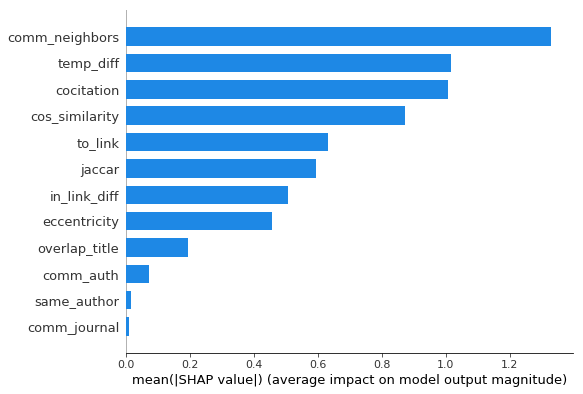

In [23]:
# feature importance in model predictions
shap.summary_plot(shap_values, Xtrain, plot_type='bar',show = False )
import matplotlib.pyplot as pl

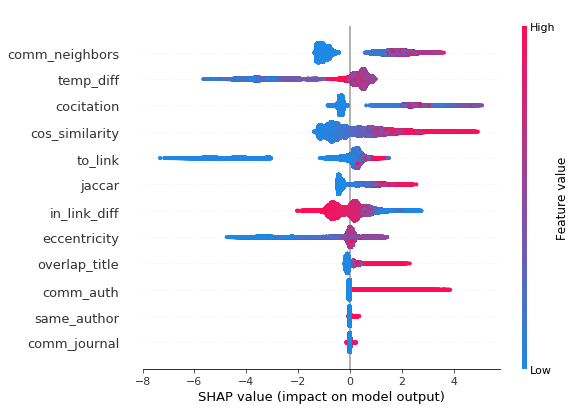

In [22]:
shap.summary_plot(shap_values, Xtrain)
# if common_neighbors,cos_similarity,comm_auth is high, shapley value is high which means there is a high chance to classify it as 1
# the lower temp_diff is, the lower the shapley value gets making the pair less likely to be classified as 1

In [24]:
#Impact of features on an output value 
shap.force_plot(explainer.expected_value, shap_values[0,:], Xtrain.iloc[0,:])

